# Demo of consensus clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [2]:
def plot_synth_cons_par(X, labels_cons,labels_par, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_cons[i]),s=74,alpha=0.2)

    plt.xticks([]), plt.yticks([])

    plt.title('Consensus Clustering')   
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_par[i]),s=74,alpha=0.2)
    plt.xticks([]), plt.yticks([])
    
    plt.title('Highest NMI with Consensus Clustering')
    
    if savetitle:
        plt.savefig(savetitle, transparent = True)

## Spiral Data set

In [3]:
from consensus_clustering.load_data import load_spiral_data, scale_data
data = load_spiral_data(scale = 'True')
#data = load_uneven_blobs()

Fit some KMeans and DBSCAN objects

In [4]:
no_labels = [0] * len(data)
num_objects = 5
dbscan_objects = [None] * num_objects
kmeans_objects = [None] * num_objects
spectral_objects = [None] * num_objects
ms_objects = [None] * num_objects
dbscan_obj = None
kmeans_obj = None
spectral_obj = None
ms_obj = None

# Fit some DBSCAN objects
eps_array = np.linspace(0.5, 1.5, num_objects)
minPts_start = 6
minPts_array = np.arange(minPts_start, minPts_start + num_objects)
for i, (eps, minPts) in enumerate(zip(eps_array, minPts_array)):
    dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
    dbscan_obj.fit()
    dbscan_objects[i] = dbscan_obj

# Fit some KMeans objects
num_clusters_start = 2
num_clusters_array = np.arange(num_clusters_start, num_clusters_start + num_objects)
for i, k in enumerate(num_clusters_array):
    kmeans_obj = cl_dist.KMeans(data, k=k, verbose=False)
    kmeans_obj.fit()
    kmeans_objects[i] = kmeans_obj
    
#Fit some Spectral Clustering objects
#k_sp = 3
#bandwidth_array = np.linspace(0.5,4.5,num_objects)
#for i, j in enumerate(bandwidth_array):
#    spectral_obj = similarity.SpectralClustering(data, k=k_sp, bandwidth=j,verbose=False)
#    spectral_obj.fit()
#    spectral_objects[i] = spectral_obj
    
#Fit some Mean Shift objects
mindist = 0.03
bandwidthms_array = np.linspace(0.3,0.65,num_objects)
for i, j in enumerate(bandwidthms_array):
    ms_obj = density.MeanShift(data, bandwidth= j, mindist = mindist, verbose = False)
    ms_obj.fit()
    ms_objects[i] = ms_obj


Find a consensus

In [5]:
clusterings = [*kmeans_objects, *dbscan_objects, *ms_objects]
num_objects2=len(clusterings)
recluster_what = 'points'
how = 'hierarchical'
k=3

# Fit consensus
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how, verbose=False)
consensus_labels = consensus_obj.cluster_labels

Plot results

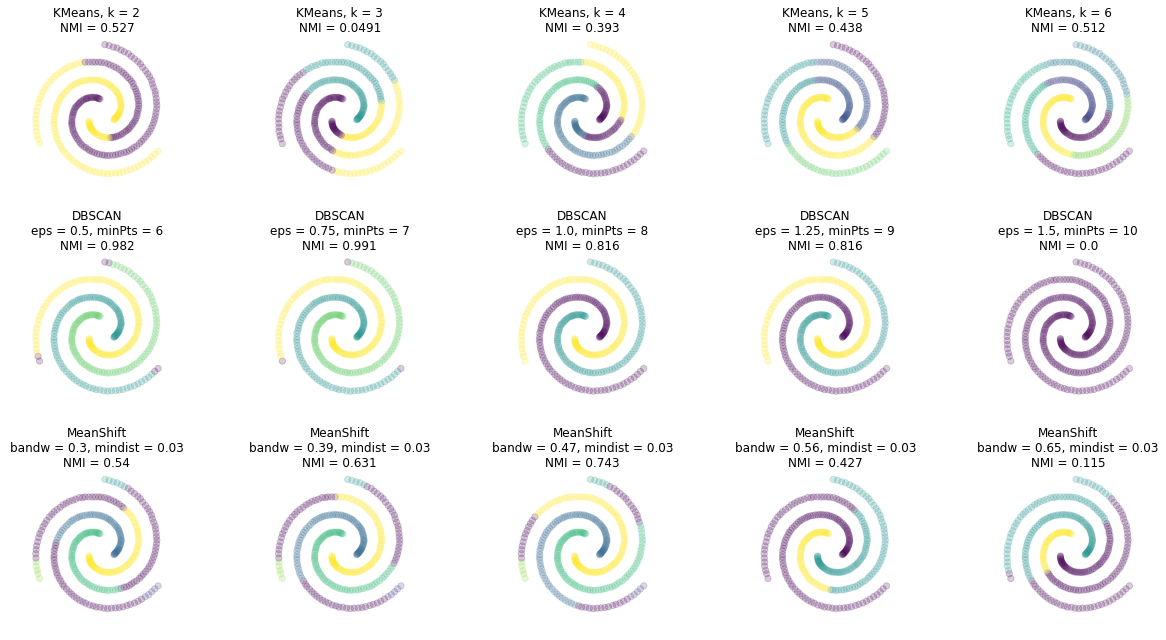

In [6]:
# Calculate NMI's
# Put labels in right order in to the labels array
labels = []
nmi_array = np.zeros(num_objects2)
for i, obj in enumerate(clusterings):
    nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    #print(obj.cluster_labels)
    labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)

# Init plotting arrangement
num_plots = num_objects2
num_subplts_per_row = 5
num_rows = num_plots // num_subplts_per_row
num_cols = min(num_subplts_per_row, num_plots)
f, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

# Plot labels
for i, ax in enumerate(axarr.flat):
    #format_square(ax, min(data[:, 0]), max(data[:, 0]), min(data[:, 1]), max(data[:, 1]))
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], s=40, c=labels[i], alpha=0.2)
    ax.axis('off')
    if i < num_subplts_per_row :
        ax.set_title('KMeans, k = {:}\nNMI = {:.3}'.format(num_clusters_array[i],nmi_array[i]))
    elif i < 2*num_subplts_per_row:
        ax.set_title('DBSCAN\neps = {:}, minPts = {:}\nNMI = {:.3}'.format(eps_array[i-num_subplts_per_row], minPts_array[i-num_subplts_per_row],nmi_array[i]))
    #elif i < 3*num_subplts_per_row:
     #   ax.set_title('Spectral\nbandw = {:}, k = {:}\nNMI = {:.3}'.format(bandwidth_array[i-2*num_subplts_per_row],k_sp,nmi_array[i]))
    elif i < 3*num_subplts_per_row:
        ax.set_title('MeanShift\nbandw = {:.2}, mindist = {:}\nNMI = {:.3}'.format(bandwidthms_array[i-3*num_subplts_per_row], mindist,nmi_array[i]))    
plt.tight_layout()
plt.savefig('img/spiral_alg_search.png', transparent = True)
plt.show()


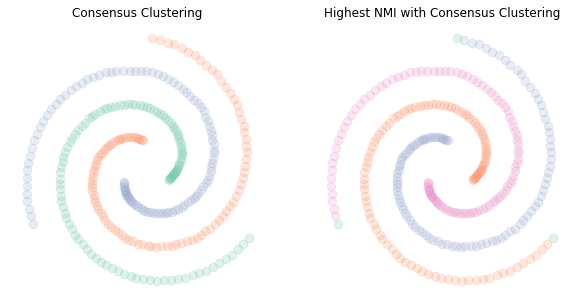

In [7]:
#highest NMI with consensus
best=np.argmax(nmi_array)

obj=clusterings[best]
labels_alg_search=consensus_obj._noise_to_zero(obj).cluster_labels

plot_synth_cons_par(data,consensus_obj.cluster_labels.astype(int),labels_alg_search,figsize = (10,5),savetitle = 'img/spiral_consensus.png')

In [8]:
print("The best algorithm choice (given the chosen range) has NMI ", np.max(nmi_array), " compared to the consensus result")

The best algorithm choice (given the chosen range) has NMI  0.990830456037  compared to the consensus result


Something is strange here about the NMI. The labelling that should be correct (eg. DBSCAN with minpts 8 und 9) has a lower NMI with the consensus clustering. 

In [9]:
#dbschan minpts 7
obj=clusterings[6]
labels_alg_search=consensus_obj._noise_to_zero(obj).cluster_labels
print(labels_alg_search)

#dbschan minpts 8
obj2=clusterings[7]
labels_alg_search2=consensus_obj._noise_to_zero(obj2).cluster_labels
print(labels_alg_search2)

[-1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [10]:
consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)

0.99083045603664222

In [11]:
consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj2).cluster_labels)

0.81628864636924348

In [12]:
consensus_obj.cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

Is it problem that some cluster labels are -1? (i.e. noise?)